# Exploratory Data Analysis

# Setup

In [1]:
import pandas as pd
import janitor
import os
import sys
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from eda_utils import add_gbp_columns, explode_lists
from stats_builder import make_summary_df, calculate_stats, make_calculated_df, format_stats, format_df
from plots_builder import make_bar_chart
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

# Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve all records, in order to start building my analysis dataframes. I will create one dataframe for funder information, and another for grants and recipients information.

In [2]:
#get tables and build dataframes
tables = ["funders", "causes", "areas", "beneficiaries", "grants",
               "funder_causes", "funder_areas", "funder_beneficiaries", "funder_grants", 
               "financials", "funder_financials"]

for table in tables:
    globals()[table] = get_table_from_supabase(url, key, table)

#get recipients with filter
recipients = get_table_from_supabase(url, key, "recipients", batch_size=50, filter_recipients=True)
all_recipient_ids = set(recipients["recipient_id"].unique())

#get and filter recipient join tables
recipient_join_tables = ["recipient_grants", "recipient_areas", "recipient_beneficiaries", "recipient_causes"]
for table in recipient_join_tables:
    df = get_table_from_supabase(url, key, table)
    globals()[table] = df[df["recipient_id"].isin(all_recipient_ids)]

print(f"Loaded {len(funders)} funders, {len(recipients)} recipients, {len(grants)} grants")
print(f"Filtered recipient join tables to {len(all_recipient_ids)} valid recipients")

Loaded 996 funders, 18527 recipients, 32815 grants
Filtered recipient join tables to 18527 valid recipients


## The Funders Dataframe

### Main Table

In [3]:
funders_df = funders.copy()

#define table relationships for funders
funder_rels = [
    {
        "join_table": funder_causes,
        "lookup_table": causes,
        "key": "cause_id",
        "value_col": "cause_name",
        "result_col": "causes"
    },
    {
        "join_table": funder_areas,
        "lookup_table": areas,
        "key": "area_id",
        "value_col": "area_name",
        "result_col": "areas"
    },
    {
        "join_table": funder_beneficiaries,
        "lookup_table": beneficiaries,
        "key": "ben_id",
        "value_col": "ben_name",
        "result_col": "beneficiaries"
    }
]

#group and merge
for rel in funder_rels:
    grouped = rel["join_table"].merge(rel["lookup_table"], on=rel["key"])
    grouped = grouped.groupby("registered_num")[rel["value_col"]].apply(list).reset_index()
    grouped.columns = ["registered_num", rel["result_col"]]
    funders_df = funders_df.merge(grouped, on="registered_num", how="left")

#add grant statistics columns 
grants_stats = funder_grants.merge(grants, on="grant_id")
grants_agg = grants_stats.groupby("registered_num").agg({
    "grant_id": "count",
    "amount": ["sum", "mean", "median"]
}).reset_index()
grants_agg.columns = ["registered_num", "num_grants", "total_given", "avg_grant", "median_grant"]

funders_df = funders_df.merge(grants_agg, on="registered_num", how="left")
funders_df["num_grants"] = funders_df["num_grants"].astype("Int64")

#replace nan values with empty lists
funders_df["causes"] = funders_df["causes"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["areas"] = funders_df["areas"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["beneficiaries"] = funders_df["beneficiaries"].apply(lambda x: x if isinstance(x, list) else [])

#round to 2 decimal places
funders_df = funders_df.round(2)
pd.set_option("display.float_format", "{:.2f}".format)

#format financial columns
float_cols = ["income_latest", "expenditure_latest", "total_given", "avg_grant", "median_grant"]
for col in float_cols:
    if col in funders_df.columns:
        funders_df[col + "_gbp"] = funders_df[col].apply(add_gbp_columns)

### Financial History Table

In [4]:
#get full financial records and separate into income and expenditure
financial_history = funder_financials.merge(financials, on="financials_id")
income_history = financial_history[financial_history["financials_type"] == "income"]
expenditure_history = financial_history[financial_history["financials_type"] == "expenditure"]

#make financials dicts
income_by_funder = income_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
income_by_funder.columns = ["registered_num", "income_history"]

expenditure_by_funder = expenditure_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
expenditure_by_funder.columns = ["registered_num", "expenditure_history"]

#merge with funders and replace nans
funders_df = funders_df.merge(income_by_funder, on="registered_num", how="left")
funders_df = funders_df.merge(expenditure_by_funder, on="registered_num", how="left")
funders_df["income_history"] = funders_df["income_history"].apply(lambda x: x if isinstance(x, dict) else {})
funders_df["expenditure_history"] = funders_df["expenditure_history"].apply(lambda x: x if isinstance(x, dict) else {})

### The List Entries

In [5]:
#get list entries
list_entries = get_table_from_supabase(url, key, "list_entries")
funder_list = get_table_from_supabase(url, key, "funder_list")
list_with_info = funder_list.merge(list_entries, on="list_id")

#get list of entries for each funder
list_grouped = list_with_info.groupby("registered_num")["list_info"].apply(list).reset_index()
list_grouped.columns = ["registered_num", "list_entries"]

#merge with funders and replace nans
funders_df = funders_df.merge(list_grouped, on="registered_num", how="left")
funders_df["list_entries"] = funders_df["list_entries"].apply(lambda x: x if isinstance(x, list) else [])

In [6]:
#extend column view, sort and preview funders
pd.set_option("display.max_columns", 100)
funders_df = funders_df.sort_values("total_given_gbp", ascending=False)
funders_df.head()

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_single_ben_funder,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries
819,288086,FARRER AND CO CHARITABLE TRUST,https://www.farrer.co.uk,THE MAIN PURPOSE OF THE TRUST IS TO APPLY INCO...,IN OR TOWARDS THE GENERAL PURPOSES OF SUCH CHA...,80569.00,78229.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],[Other Charities Or Voluntary Bodies],14,97590.14,6970.72,4000.00,"£80,569.00","£78,229.00","£97,590.14","£6,970.72","£4,000.00","{2020: 78285.0, 2021: 52439.0, 2022: 79299.0, ...","{2020: 76431.0, 2021: 61395.0, 2022: 76795.0, ...",[]
897,1041449,MIRACLES,https://www.miraclesthecharity.org,MIRACLES IS A CHARITY OFFERING HOPE FOR THOSE ...,THE RELIEF OF POVERTY AND HARDSHIP OF PERSONS ...,351143.00,908121.00,THE AIMS AND OBJECTS OF MIRACLES REMAIN TO PRO...,THIRTY-ONE YEARS ON SINCE THE LAUNCH OF MIRACL...,None,False,False,"[General Charitable Purposes, Education/traini...","[Scotland, Europe, Throughout England]",[The General Public/mankind],8,96073.00,12009.12,2750.00,"£351,143.00","£908,121.00","£96,073.00","£12,009.12","£2,750.00","{2020: 235183.0, 2021: 325035.0, 2022: 303775....","{2020: 322068.0, 2021: 337276.0, 2022: 274309....",[]
831,526956,KELSICK'S EDUCATIONAL FOUNDATION,https://www.kelsick.org.uk,TO PROVIDE GRANTS FOR EDUCATIONAL NEEDS TO YOU...,"1)THE PROVISION OF SPECIAL BENEFITS, OF ANY KI...",411338.00,408717.00,THE NET OPERATING SURPLUS FOR THE YEAR WAS NEA...,THE NET OPERATING SURPLUS FOR THE YEAR WAS NEA...,None,False,False,[Education/training],[Cumbria],"[Children/young People, People With Disabiliti...",17,956424.00,56260.24,58800.00,"£411,338.00","£408,717.00","£956,424.00","£56,260.24","£58,800.00","{2020: 416991.0, 2021: 387390.0, 2022: 407536....","{2020: 408890.0, 2021: 381641.0, 2022: 382351....",[]
805,260741,A P TAYLOR TRUST,https://www.aptaylortrust.org.uk,THE YEARLY INCOME OF THE FUND PROVIDED BY THE ...,FUND FOR THE USE OF THE INHABITANTS OF THE PAR...,111430.00,136811.00,OBJECTS AND AIMS THE YEARLY INCOME OF THE FUND...,None,"DURING THE YEAR, A TOTAL AMOUNT OF £36,450 WAS...",False,False,"[General Charitable Purposes, The Advancement ...","[Hillingdon, Greater London]","[Children/young People, Elderly/old People, Pe...",75,95240.00,1269.87,300.00,"£111,430.00","£136,811.00","£95,240.00","£1,269.87",£300.00,"{2020: 112954.0, 2021: 105886.0, 2022: 98342.0...","{2020: 114393.0, 2021: 124987.0, 2022: 114089....",[]
102,270718,FRANCIS COALES CHARITABLE FOUNDATION,https://franciscoales.co.uk,TO ASSIST WITH GRANTS FOR THE STRUCTURAL REPAI...,TO PROVIDE FUNDS DIRECTLY OR BY WAY OF GRANT O...,117420.00,118765.00,THE OBJECT OF THE FOUNDATION IS TO ASSIST WITH...,"IN 2024, 22 (2023: 25) APPLICATIONS WERE CONSI...",None,False,False,[Environment/conservation/heritage],"[Buckinghamshire, Hertfordshire, Northamptonsh...",[Other Defined Groups],3,93953.00,31317.67,5000.00,"£117,420.00","£118,765.00","£93,953.00","£31,317.67","£5,000.00","{2020: 111553.0, 2021: 134468.0, 2022: 149302....","{2020: 129452.0, 2021: 132270.0, 2022: 120004....",[]


## The Grants Dataframe

### Main Table

In [7]:
grants_df = grants.copy()

#add funder info
grants_df = grants_df.merge(funder_grants, on="grant_id")
grants_df = grants_df.merge(funders[["registered_num", "name"]], on="registered_num")
grants_df = grants_df.rename(columns={"name": "funder_name"})
grants_df = grants_df.rename(columns={"registered_num": "funder_num"})

#add recipient info  
grants_df = grants_df.merge(recipient_grants, on="grant_id")
grants_df = grants_df.merge(recipients[["recipient_id", "recipient_name", "recipient_activities"]], 
                        on="recipient_id", 
                        how="left")

#add recipient areas
recip_areas_grouped = recipient_areas.merge(areas, on="area_id")
recip_areas_grouped = recip_areas_grouped.groupby("recipient_id")["area_name"].apply(list).reset_index()
recip_areas_grouped.columns = ["recipient_id", "recipient_areas"]
grants_df = grants_df.merge(recip_areas_grouped, on="recipient_id", how="left")

#add recipient causes
recip_causes_grouped = recipient_causes.merge(causes, on="cause_id")
recip_causes_grouped = recip_causes_grouped.groupby("recipient_id")["cause_name"].apply(list).reset_index()
recip_causes_grouped.columns = ["recipient_id", "recipient_causes"]
grants_df = grants_df.merge(recip_causes_grouped, on="recipient_id", how="left")

#add recipient beneficiaries
recip_beneficiaries_grouped = recipient_beneficiaries.merge(beneficiaries, on="ben_id")
recip_beneficiaries_grouped = recip_beneficiaries_grouped.groupby("recipient_id")["ben_name"].apply(list).reset_index()
recip_beneficiaries_grouped.columns = ["recipient_id", "recipient_beneficiaries"]
grants_df = grants_df.merge(recip_beneficiaries_grouped, on="recipient_id", how="left")

#replace nan values with empty lists
if "recipient_areas" in grants_df.columns:
    grants_df["recipient_areas"] = grants_df["recipient_areas"].apply(lambda x: x if isinstance(x, list) else [])
if "recipient_causes" in grants_df.columns:
    grants_df["recipient_causes"] = grants_df["recipient_causes"].apply(lambda x: x if isinstance(x, list) else [])
if "recipient_beneficiaries" in grants_df.columns:
    grants_df["recipient_beneficiaries"] = grants_df["recipient_beneficiaries"].apply(lambda x: x if isinstance(x, list) else [])

#add source of grant
grants_df["source"] = grants_df["grant_id"].apply(lambda x: "Accounts" if str(x).startswith("2") else "360Giving")

#round to 2 decimal places
grants_df = grants_df.round(2)

#format financial columns
grants_df["amount_gbp"] = grants_df["amount"].apply(add_gbp_columns)

In [8]:
#sort and preview grants
grants_df = grants_df.sort_values("recipient_id", ascending=True)
grants_df.head()

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp
9914,GRANT TO TANYARD YOUTH PROJECT LTD,REFURBISHMENT OF A FILM AND MUSIC STUDIO FOR A...,20000.00,2024,360G-ClothworkersFdn-202300599,274100,48515,CLOTHWORKERS' FOUNDATION,110884,47327,TANYARD YOUTH PROJECT LTD,None,[],[],[],360Giving,"£20,000.00"
18353,TASK TO DIGITAL VOICE FOR COMMUNITIES,TOWARDS PROJECT COSTS TOWARDS A PROJECT CALLED...,12000.00,2014,360G-EFF-14-0356,200051,56815,ESMEE FAIRBAIRN FOUNDATION,'n/a',55627,DIGITAL VOICE FOR COMMUNITIES,None,[],[],[],360Giving,"£12,000.00"
1377,CRESWELL GETS MORE CREATIVE,"THIS 22-MONTH PROJECT IN CRESWELL, DERBYSHIRE,...",8768.00,2022,360G-PeoplesHealthTrust-2022_56,1125537,40149,PEOPLE'S HEALTH TRUST,0515303,38959,JUNCTION ARTS LTD,THE PRINCIPAL ACTIVITY OF THE COMPANY IS THE P...,[Derbyshire],[],[],360Giving,"£8,768.00"
1354,FEMALE SUPPORT GROUP,THIS TWO-YEAR PROJECT BRINGS TOGETHER WOMEN OF...,6000.00,2022,360G-PeoplesHealthTrust-2022_72,1125537,40128,PEOPLE'S HEALTH TRUST,0516838,38938,BIRMINGHAM CITY CLUBS FOR YOUNG PEOPLE,TO PROVIDE YOUNG PEOPLE WITH A RANGE OF RECREA...,"[Birmingham City, West Midlands, Warwickshire]",[],[],360Giving,"£6,000.00"
1312,YOUNG PARENTS' GROUP,THIS TWO-YEAR PROJECT PROVIDES A WEEKLY MEETIN...,0.00,2022,360G-PeoplesHealthTrust-2022_128,1125537,40088,PEOPLE'S HEALTH TRUST,0700733,38898,SIDEWALK YOUTH ORGANISATION,THE SIDEWALK YOUTH ORGANISATION HAS BEEN WORKI...,[North Yorkshire],[],[],360Giving,£0.00


# Summary Statistics

In [9]:
#build df of summary statistics
summary_data = make_summary_df(funders_df, grants_df)
summary_df = pd.DataFrame(summary_data)
summary_df["Value"] = summary_df.apply(format_stats, axis=1)
summary_df = format_df(summary_df)

Metric,Value
Total funders,996
Funders with grants,309
Total recipients,"18,527"
Total grants,"32,815"
Total grant value,"£1,449,032,528.75"
Mean grants per funder,106
Most grants given by a funder,"6,987"
Fewest grants given by a funder,1
Mean recipients per funder,69.3
Mean areas per funder,3.6


# Calculated Statistics

In [10]:
#get calculated stats and build df
stats = calculate_stats(funders_df, grants_df)
calculated_data = make_calculated_df(stats)
calculated_df = pd.DataFrame(calculated_data)
calculated_df["Value"] = calculated_df.apply(format_stats, axis=1)
calculated_df = format_df(calculated_df)

Metric,Value
Share of grants from top 10% funders (by income),71.6%
Share of grants to top 10% recipients (by grant value),71.7%
Percent of recipients with multiple grants from same funder,28.7%
Average grants per funder-recipient pair,2
Mean grants-to-income ratio,120.6%
Median grants-to-income ratio,72.2%
Percent of funders supporting General Charitable Purposes only,16.8%


# Data Quality

## 1. Missingness

I will view the structure of each dataframe to check for missing data and confirm that datatypes are correct.

### Analysis of Missingness in Funders Dataframe

In [11]:
funders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 819 to 498
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   registered_num            996 non-null    object 
 1   name                      996 non-null    object 
 2   website                   497 non-null    object 
 3   activities                991 non-null    object 
 4   objectives                996 non-null    object 
 5   income_latest             996 non-null    float64
 6   expenditure_latest        996 non-null    float64
 7   objectives_activities     230 non-null    object 
 8   achievements_performance  194 non-null    object 
 9   grant_policy              52 non-null     object 
 10  is_single_ben_funder      996 non-null    bool   
 11  is_on_list                996 non-null    bool   
 12  causes                    996 non-null    object 
 13  areas                     996 non-null    object 
 14  beneficiaries

In [12]:
#missing activities - check manually
funders_df[funders_df["activities"].isna()]

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_single_ben_funder,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries
601,1207622,UNITED 4 PEACE,None,None,THE OBJECTS OF THE CIO ARE:\r\n\r\n1.\tTHE PRE...,28392.00,27547.00,None,None,None,False,False,"[General Charitable Purposes, The Prevention O...","[Lebanon, Asia, Turkey, Yemen, Jordan, Pakista...","[Children/young People, Elderly/old People, Ot...",<NA>,NaN,NaN,NaN,"£28,392.00","£27,547.00",,,,{2024: 28392.0},{2024: 27547.0},[]
735,1203444,JIDCUK CHARITABLE TRUST,None,None,TO ADVANCE THE EDUCATION OF THE PUBLIC IN GENE...,199513.00,69994.00,None,None,None,False,False,[Education/training],"[Fiji, Oceania, Nigeria, Africa, Zimbabwe, Nep...",[],<NA>,NaN,NaN,NaN,"£199,513.00","£69,994.00",,,,{2024: 199513.0},{2024: 69994.0},[]
707,1203389,AZOUZ FOUNDATION,None,None,THE TRUSTEES SHALL HOLD THE TRUST FUND AND THE...,277373.00,266756.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],"[Other Charities Or Voluntary Bodies, The Gene...",<NA>,NaN,NaN,NaN,"£277,373.00","£266,756.00",,,,{2024: 277373.0},{2024: 266756.0},[]
537,1203342,LOVE GREY FOUNDATION,https://www.lovegrey.org,None,"THE OBJECTS OF THE CHARITY ARE, FOR THE PUBLIC...",807.00,0.00,None,None,None,False,False,"[General Charitable Purposes, Disability]",[Throughout England And Wales],[Other Charities Or Voluntary Bodies],<NA>,NaN,NaN,NaN,£807.00,£0.00,,,,{2024: 807.0},{2024: 0.0},[]
380,1204043,ZICHRON CHAIM LIMITED,None,None,TO ADVANCE SUCH CHARITABLE PURPOSES FOR THE BE...,11357.00,11106.00,None,None,None,False,False,"[General Charitable Purposes, Education/traini...",[Throughout England And Wales],[People Of A Particular Ethnic Or Racial Origi...,<NA>,NaN,NaN,NaN,"£11,357.00","£11,106.00",,,,{2024: 11357.0},{2024: 11106.0},[]


In [13]:
#missing sections - check proportion of funders with sections extracted from accounts
has_sections = funders_df[
    funders_df["objectives_activities"].notna() |
    funders_df["achievements_performance"].notna() |
    funders_df["grant_policy"].notna()
]

has_sections_total = len(has_sections)
has_sections_proportion = has_sections_total / 996

print(f"Funders with accessible accounts: 327")
print(f"Funders with extracted sections: {has_sections_total}")
print(f"Proportion of funders with sections: {has_sections_proportion:.2%}")


Funders with accessible accounts: 327
Funders with extracted sections: 243
Proportion of funders with sections: 24.40%


### Exploration of Findings from Missingness Analysis (Funders)

There are five funders in the database with empty `activities`. I have checked the Charity Commission website and it does appear that these funders have simply not declared any activities. They are all relatively new having submitted only one set of accounts. The `activities_objectives` column has not been populated for any of these funders, which is unfortunate as this could have provided a further source of information. One of these funders has a website so, if I am able to achieve my stretch target of scraping websites, this may offer details (although at the time of writing, the website does not exist).

**Problem with Accounts**

My database building scripts (for PDFs) have a serious limitation as I am unable to scrape the Charity Commission website for accounts where the page contains JavaScript. The older pages, which are basic HTML, are accessible but the newer ones are not, and I am unable to tell which charities have been updated to the new system until the script attempts to scrape them and fails. Having built the database, I can now see from the print statements that 327 funders have accessible accounts, representing 32.8% of the 996 funders in the sample. My calculations above show that the required sections have been extracted from accounts for 24.4% of funders - varying from 52 funders with `grant_policy`, to 194 funders with `achievements_peformance` and 230 funders with `objectives_activities`.

### Analysis of Missingness in Grants Dataframe

In [14]:
grants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33147 entries, 9914 to 68
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   grant_title              18116 non-null  object 
 1   grant_desc               18116 non-null  object 
 2   amount                   33101 non-null  float64
 3   year                     33147 non-null  int64  
 4   grant_id                 33147 non-null  object 
 5   funder_num               33147 non-null  object 
 6   funder_grants_id         33147 non-null  int64  
 7   funder_name              33147 non-null  object 
 8   recipient_id             33147 non-null  object 
 9   recipient_grants_id      33147 non-null  int64  
 10  recipient_name           33147 non-null  object 
 11  recipient_activities     15829 non-null  object 
 12  recipient_areas          33147 non-null  object 
 13  recipient_causes         33147 non-null  object 
 14  recipient_beneficiaries  33

In [15]:
#missing grant title and description - check numbers per source
missing_by_source = grants_df.groupby("source").agg({
    "grant_title": lambda x: x.isna().sum(),
    "grant_desc": lambda x: x.isna().sum(),
    "grant_id": "count"
}).rename(columns={"grant_id": "total_grants", "grant_title": "missing_title", "grant_desc": "missing_desc"})

print(missing_by_source)

           missing_title  missing_desc  total_grants
source                                              
360Giving              0             0         18116
Accounts           15031         15031         15031


In [16]:
#missing grant amounts - spotcheck manually
missing_amounts = grants_df[grants_df["amount"].isna()].sort_values("funder_num", ascending=True)
missing_amounts.head()

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp
24861,None,None,NaN,2021,2021_1017255_16,1017255,65288,REALL LIMITED,PDF-002953,64098,SHELTERS (ZIMBABWE),None,[],[],[],Accounts,
20477,None,None,NaN,2021,2021_1052958_15,1052958,59612,TRIODOS FOUNDATION,PDF-000100,58423,YOUNG & FREE,None,[],[],[],Accounts,
31665,None,None,NaN,2022,2022_1059451_25,1059451,72457,MILLENNIUM POINT TRUST,PDF-006134,71256,COURT FARM PRIMARY SCHOOL,None,[],[],[],Accounts,
19033,None,None,NaN,2023,2023_217929_7,217929,67274,BARTON UNDER NEEDWOOD AND DUNSTALL KEY TRUST,PDF-003833,66077,BARTON FESTIVAL,None,[],[],[],Accounts,
26816,None,None,NaN,2023,2023_217929_8,217929,67275,BARTON UNDER NEEDWOOD AND DUNSTALL KEY TRUST,PDF-003845,66078,PLANNED TRIPS TO BORNEO AND INDIA (FOR YOUNG P...,None,[],[],[],Accounts,


In [17]:
#missing recipient activities - compare by source
missing_recips = grants_df["recipient_activities"].isna().sum()
accounts_recips = grants_df[
    (grants_df["source"] == "Accounts") &
    (grants_df["recipient_activities"].isna())
]
missing_360g = grants_df[
    (grants_df["source"] == "360Giving") &
    (grants_df["recipient_activities"].isna())
]

print(f"Grants extracted from accounts: {len(accounts_recips):,} ({len(accounts_recips)/missing_recips*100:.1f}%)")
print(f"360Giving recipients with missing activities: {len(missing_360g):,} ({len(missing_360g)/missing_recips*100:.1f}%)")

Grants extracted from accounts: 11,486 (66.3%)
360Giving recipients with missing activities: 5,832 (33.7%)


### Exploration of Findings from Missingness Analysis (Grants)

There are 33,147 rows in the dataframe, 287 more than the number of unique grants as some grants are given to multiple recipients. The deduplication script in `stats_builder.py` ensures that the value of each grant has only been counted once for the purpose of the summary/calculated statistics.

I have explored the missing data from `grant_title` and `grant_desc` to check that only grants extracted from accounts are missing these fields. This was to be expected as these details are not available for the grants from accounts; the figures above confirm that every grant from the 360Giving API is complete with a title and description. 

Of the 32,815 grants in the database, 46 (0.14%) are missing `amount`. I have performed a spot-check of 12 grants (25%), which suggests that these are genuine extraction errors from funder accounts rather than systematic issues. I have decided to keep these 46 grants in the database as they still provide valuable information about funder-recipient relationships and giving patterns, and such a small number of missing amounts is not likely to affect analyses/models.

I also explored the 17,318 rows in `grants_df` with missing `recipient_activities`. Null values in this column are to be expected for recipients that are added following extraction from PDFs, which accounts for 11,486 (66.3%). The remaining 5,832 (33.7%) null values - which are present within records added to the database by the 360Giving API - can be explained by:
- Charities that have been removed from the Charity Commission, e.g. if they have closed down
- Registered charities that simply do not declare their activities (as present in 5 records in `funders_df`)
- Where abnormalities are evident in `registered_num`. For example, the RSPB is identified in the 360Giving API by *207076 & SC037654* - its registered numbers for both the Charity Commission of England & Wales and the Office of the Scottish Charity Regulator. My database builder script was unable to match on *207076 & SC037654* as `registered_num`. 

## 2. Word Counts

I will check the lengths of the shortest and longest text entries, to ensure that they have been imported correctly and are not too short or long for unexpected reasons. Many funders provide very short explanations of their activities/objectives etc., such as simply "grant-giving" which is just one word - so this would not be abnormal. I will confirm that particularly long entries are not corrupted or the result of multiple documents being combined accidentally.

In [18]:
#check word counts for text columns in funders df
funders_text_cols = ["activities", "objectives", "objectives_activities", "achievements_performance", "grant_policy"]

#create columns
for col in funders_text_cols:
    funders_df[f"word_count_{col}"] = funders_df[col].str.split().str.len()
for col in funders_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = funders_df[funders_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = funders_df.loc[[min_idx, max_idx],
                                    ["registered_num", "name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

ACTIVITIES
______________________________



,registered_num,name,word_count_activities,activities
Minimum,277767,WANSTEAD HIGH SCHOOL PARENT-TEACHER ASSOCIATION,1.00,FUNDRAISING
Maximum,217929,BARTON UNDER NEEDWOOD AND DUNSTALL KEY TRUST,76.00,TO PAY THE MINISTER OF THE CHURCH OF ST JAMES ...


OBJECTIVES
______________________________



,registered_num,name,word_count_objectives,objectives
Minimum,213077,EPPING AND THEYDON GARNON CHARITIES,2,SEE CONSTITUENTS
Maximum,1104413,INSPIRE HOUNSLOW,524,"3. THE OBJECTS OF THE COMPANY (THE ""OBJECTS"") ..."


OBJECTIVES_ACTIVITIES
______________________________



,registered_num,name,word_count_objectives_activities,objectives_activities
Minimum,210586,KIDDERMINSTER AID IN SICKNESS FUND,13.00,2 TO 3 BALANCE SHEET NOTES TO THE FINANCIAL ST...
Maximum,1050861,DARTFORD AND GRAVESHAM NHS TRUST CHARITABLE FUND,7736.00,13 8. OUR FUNDRAISING PRACTICES 15 9. OUR FUND...


ACHIEVEMENTS_PERFORMANCE
______________________________



,registered_num,name,word_count_achievements_performance,achievements_performance
Minimum,802125,TOMCHEI TORAH CHARITABLE TRUST,14.00,CHARITABLE ACTIVITIES DURING THE YEAR THE CHAR...
Maximum,1050861,DARTFORD AND GRAVESHAM NHS TRUST CHARITABLE FUND,7736.00,13 8. OUR FUNDRAISING PRACTICES 15 9. OUR FUND...


GRANT_POLICY
______________________________



,registered_num,name,word_count_grant_policy,grant_policy
Minimum,1057692,DOWNEND ROUND TABLE,8.00,POLICY ON SOCIAL INVESTMENT INCLUDING PROGRAM ...
Maximum,228166,EDWINA MOUNTBATTEN AND LEONORA CHILDREN'S FOUN...,2309.00,THE CHARITY RECEIVES APPLICATIONS FROM A WIDE ...


In [19]:
#check word counts for text columns in grants df
grants_text_cols = ["grant_title", "grant_desc", "recipient_activities"]

#create columns
for col in grants_text_cols:
    grants_df[f"word_count_{col}"] = grants_df[col].str.split().str.len()
for col in grants_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = grants_df[grants_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = grants_df.loc[[min_idx, max_idx],
                                    ["funder_num", "funder_name", "recipient_id", "recipient_name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

GRANT_TITLE
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_grant_title,grant_title
Minimum,1124856,ROSA FUND,1007676,COVENTRY PANAHGHAR PROJECT,1.00,WTF-COVPAN-2021
Maximum,263207,JOHN ELLERMAN FOUNDATION,360G-Ellerman-Org-9974,MORE IN COMMON,38.00,MORE IN COMMON WILL PROVIDE SUPPORT FOR THE FO...


GRANT_DESC
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_grant_desc,grant_desc
Minimum,274100,CLOTHWORKERS' FOUNDATION,1110590,UK YOUTH,1.00,0
Maximum,1091263,LONDON COMMUNITY FOUNDATION,1016912,ACLE EVENING WOMEN'S INSTITUTE,259.00,MAJORITY OF OUR SERVICE USERS ARE FROM BME COM...


RECIPIENT_ACTIVITIES
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_recipient_activities,recipient_activities
Minimum,283813,LONDON MARATHON CHARITABLE TRUST LIMITED,1020615,FOURTH FARNHAM (TONGHAM) SCOUT GROUP,1.00,SCOUTING
Maximum,1091263,LONDON COMMUNITY FOUNDATION,GB-COH-04358319,LEWISHAM MULTILINGUAL ADVICE SERVICE,500.00,LEWISHAM MULTILINGUAL ADVICE SERVICE (LMLAS) I...


Having manually checked the minimum and maximum values against their Charity Commission records, I am confident that there are no entries that are concerningly long. There do appear to be unusual values when it comes to looking at the minimum lengths (for example, a grant entitled simply 'ALPHA'), which I will scrutinise in more detail and then clean.

- Registered nums - check for anomalies
- Reimport activities for linked charities

### Recipient Names

The `recipient_name` variable has been built from two sources. The first is the [Charity Commission's Public Extract](https://register-of-charities.charitycommission.gov.uk/en/register/full-register-download), which is updated daily and includes registered charities' names as logged with the Charity Commission. These names are generally clean and standardised, though charities occasionally use trading names that differ from their official registered names.

The second source is the organisation's name as extracted from funders' accounts by the Claude API. This is significantly less reliable and is a noted limitation of this project. The reliability is affected in part by the reliance on a large language model and its fuzzy intepretations of messy text, but also due to the fact that funders' accounts are not held to any standard of enforcement in terms of the correct spelling, uniformity, or indeed accuracy of recipients' names. Examples that have been noted during the course of this project include inconsistency in pluralisation (e.g. *hospices* vs *hospice*); missing words (e.g. *British Red Cross Society* vs *British Red Cross*); and errors in punctuation (e.g. *soldiers'* vs *solider's*). 

The LLM has also at times failed to interpret account entries properly, extracting purchase descriptions as recipient names (e.g. 'cricket balls for the Year 7 team' from a PTA's accounts) or recording vague summaries as distinct recipients (e.g. 'five various causes'). These errors are particularly prevalent in accounts from single-beneficiary funders where expenditure descriptions differ structurally from multi-recipient grant listings.

Manual spot-checking is therefore essential to identify and address these inconsistencies.

# Exploration of Giving Patterns and Funder Characteristics

## 1. Categorical Variables

One of the key objectives of prospie is to help fundraisers navigate the confusing trusts landscape, which is confusing largely due to the mismatch of information that is available. Funders may indicate a particular cause or area of activity, but these do not always align with their actual giving habits. I will therefore compare the classifications that funders state (their identified causes, beneficiaries, and areas of activity) with those of the recipients who are awarded their grants.

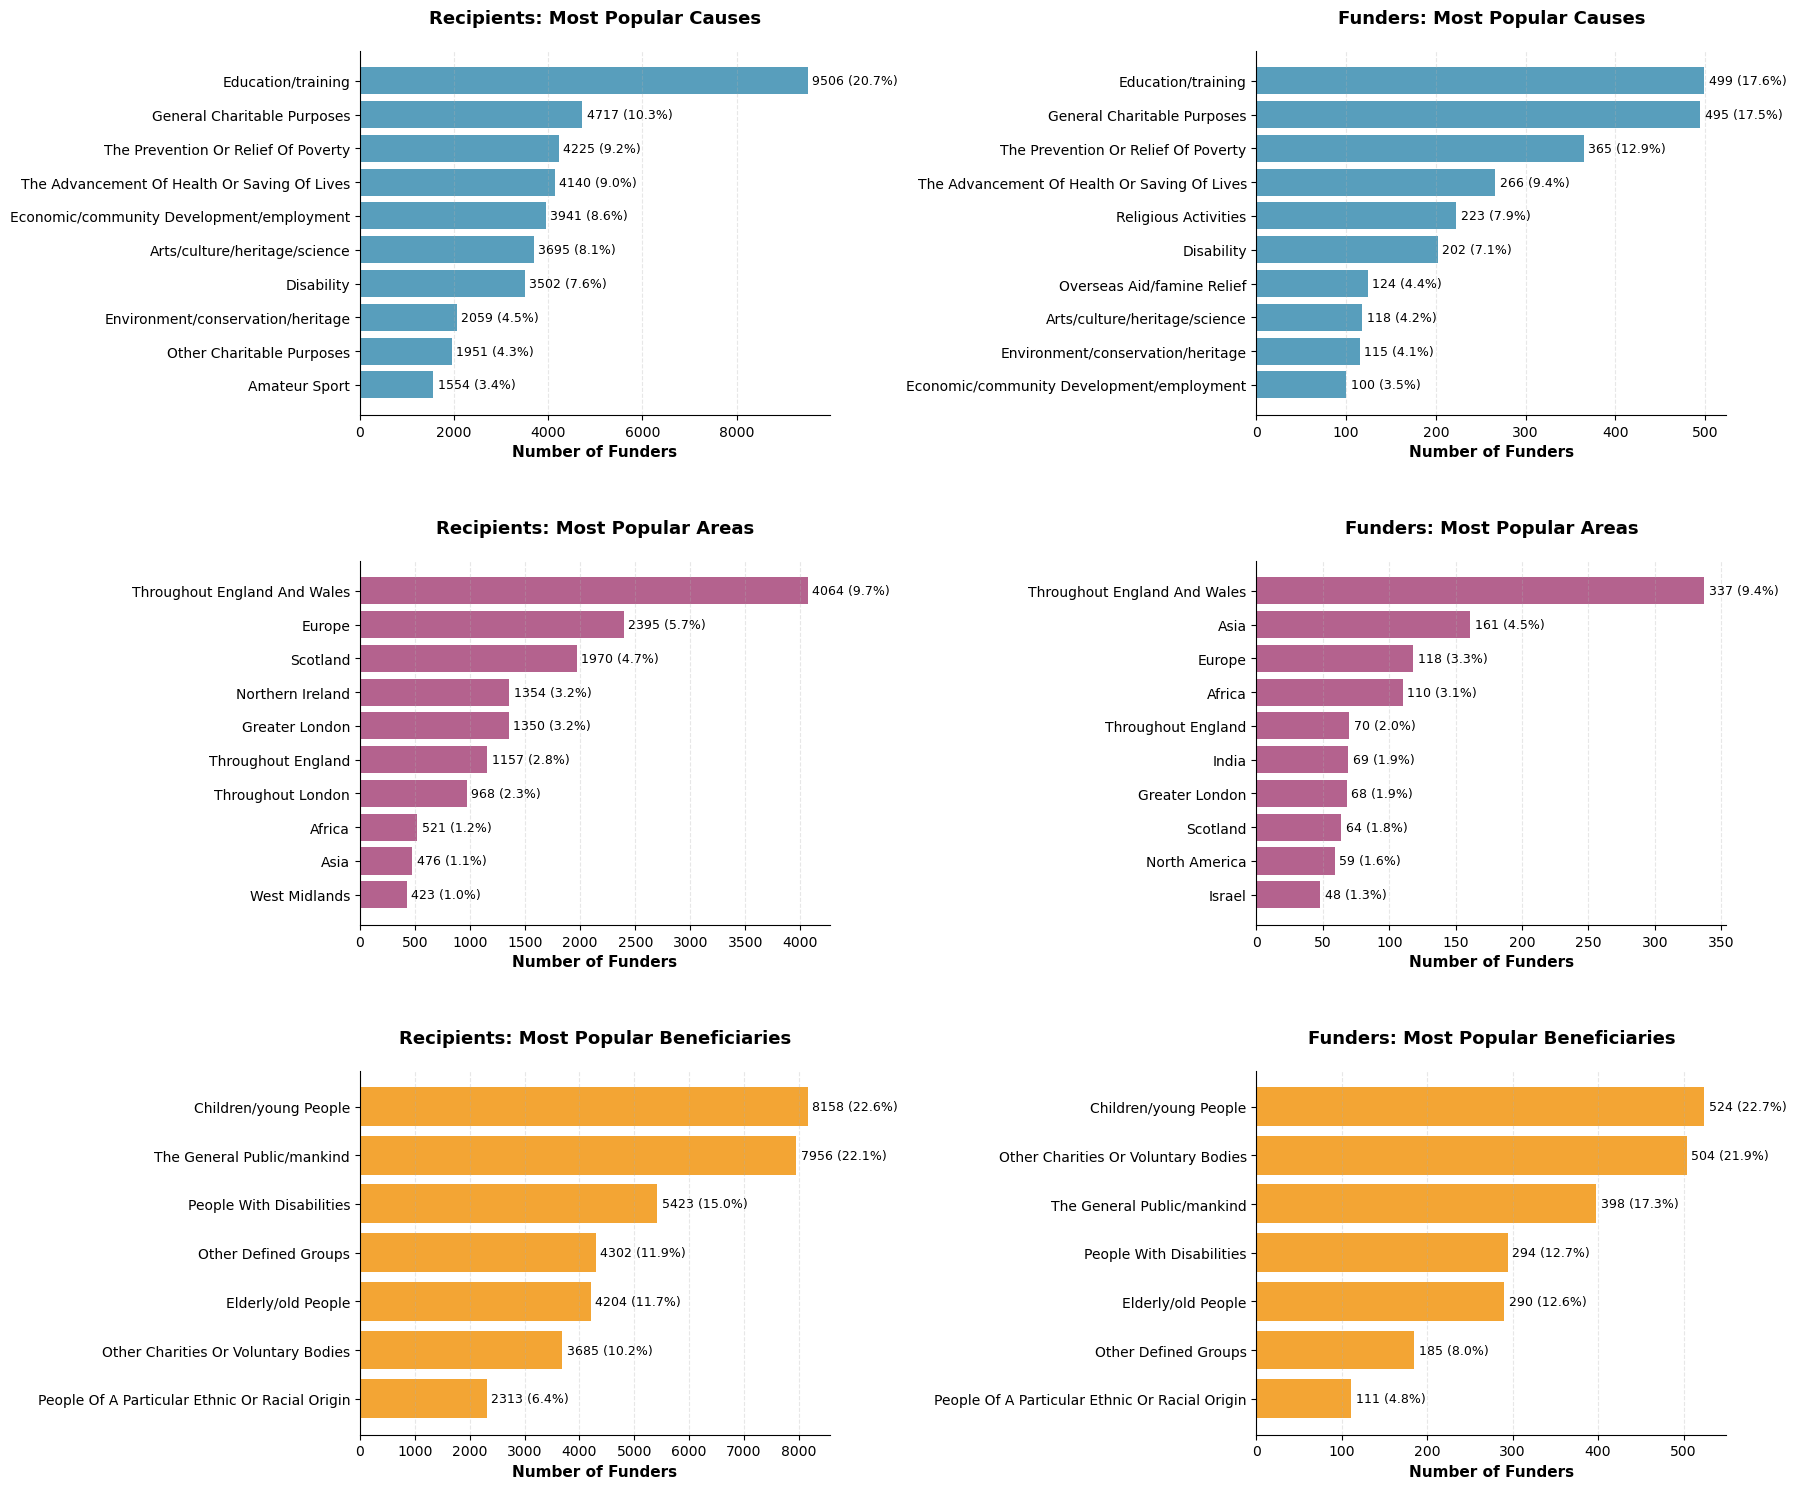

In [20]:
#display plots to compare funders' and recipients' classifications
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

#causes
make_bar_chart(grants_df, "recipient_causes", "Recipients: Most Popular Causes", color="#2E86AB", ax=axes[0, 0])
make_bar_chart(funders_df, "causes", "Funders: Most Popular Causes", color="#2E86AB", ax=axes[0, 1])

#areas
make_bar_chart(grants_df, "recipient_areas", "Recipients: Most Popular Areas", color="#A23B72", ax=axes[1, 0])
make_bar_chart(funders_df, "areas", "Funders: Most Popular Areas", color="#A23B72", ax=axes[1, 1])

#beneficiaries
make_bar_chart(grants_df, "recipient_beneficiaries", "Recipients: Most Popular Beneficiaries", color="#F18F01", ax=axes[2, 0])
make_bar_chart(funders_df, "beneficiaries", "Funders: Most Popular Beneficiaries", color="#F18F01", ax=axes[2, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

It can be observed that funders often state an interest in general causes, areas and beneficiaries - many do not specify particular interests and state that they will consider applications from any area of the sector. Further analysis will be useful, particularly following the creation of embeddings, to understand the practical reality of their funding priorities, which may reveal implicit preferences or local biases not reflected in their published criteria.

### Relationships between Categories